In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
train = pd.read_csv('/content/drive/MyDrive/datasets/tabular-letter-recognition/train.csv', encoding='utf-8-sig', engine='python')
test = pd.read_csv('/content/drive/MyDrive/datasets/tabular-letter-recognition/test.csv', encoding='utf-8-sig', engine='python')

In [87]:
train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,target
0,4,7,5,5,4,6,7,3,7,11,8,9,3,8,4,8,E
1,4,7,6,5,5,6,8,3,7,11,8,9,3,8,4,7,E
2,3,5,4,3,3,7,8,5,5,7,7,6,5,9,2,6,N
3,4,10,6,7,6,5,7,5,7,6,6,12,3,8,6,9,K
4,4,10,6,8,4,8,11,2,3,4,10,9,3,11,1,8,V


In [88]:
train.dtypes

1          int64
2          int64
3          int64
4          int64
5          int64
6          int64
7          int64
8          int64
9          int64
10         int64
11         int64
12         int64
13         int64
14         int64
15         int64
16         int64
target    object
dtype: object

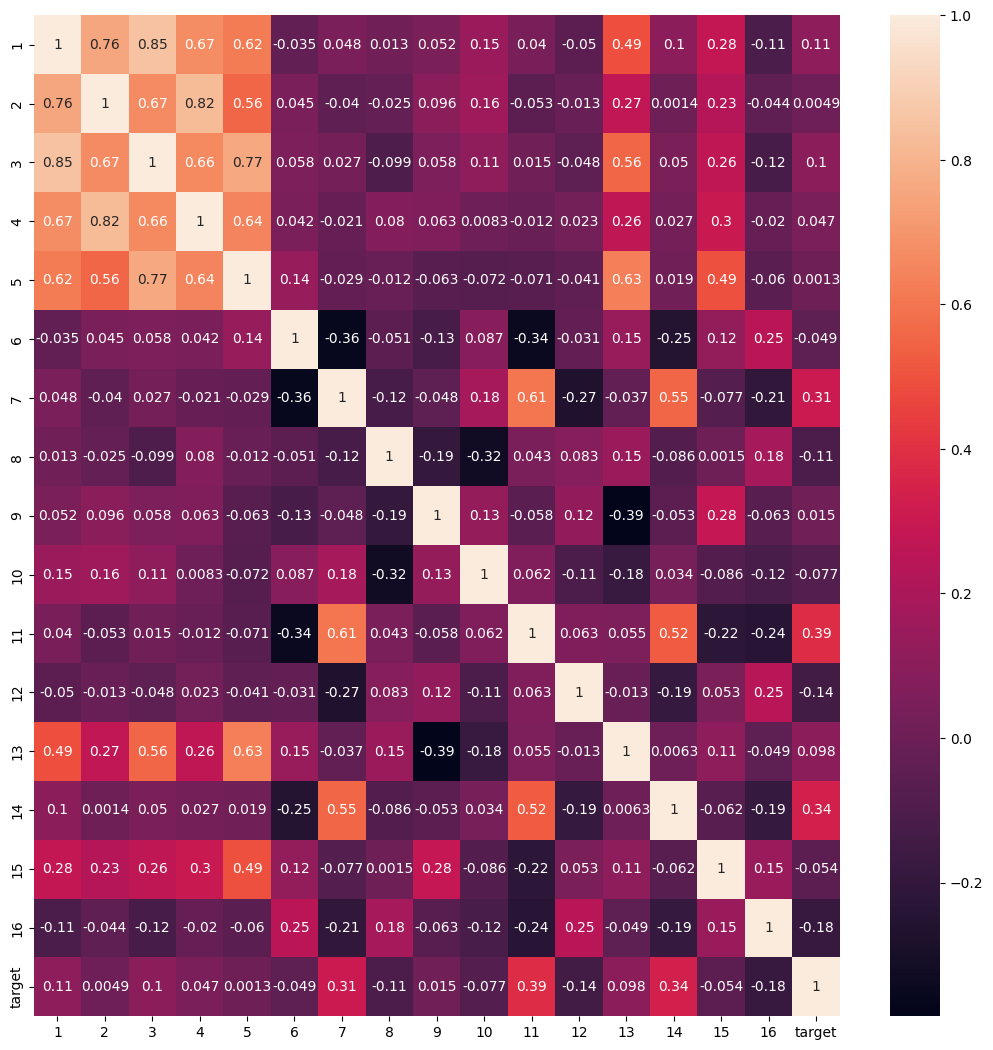

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

df = train

# Convert target column to integer values
df['target'] = df['target'].astype('category').cat.codes

# Compute correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(13, 13))
sns.heatmap(correlation_matrix, annot=True)
plt.show()




In [90]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [91]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test = scaler.transform(X_test)


In [92]:
from sklearn.preprocessing import LabelEncoder

# le is the LabelEncoder used to encode the original labels
le = LabelEncoder()

# Fit and transform the original labels
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [93]:
y_test

array([19, 11,  0, ..., 16, 24, 24])

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
import numpy as np

class StackedEnsemble:
    def __init__(self, base_models, meta_models):
        self.base_models = base_models
        self.meta_models = meta_models

    def fit(self, X, y):
        self.base_models_ = [clone(x) for x in self.base_models]
        self.meta_models_ = [clone(x) for x in self.meta_models]
        predictions = np.zeros((X.shape[0], len(self.base_models)))

        # Train base models -
        # Here, base models are individual models that
        # make up the initial layer of the ensemble model
        for i, model in enumerate(self.base_models_):
            model.fit(X, y)
            predictions[:, i] = model.predict(X)

        # Train meta models -
        # these models are trained on the prediction
        # of the base models
        for model in self.meta_models_:
            model.fit(predictions, y)

    def predict(self, X):

        # creates a 2D array
        # X.shape[0] = number of rows in the dataset
        # len(self.base_models) = number of base models in the dataset
        base_predictions = np.zeros((X.shape[0], len(self.base_models)))

        # Generate base model predictions
        # and store them in the 2D array
        for i, model in enumerate(self.base_models_):
            base_predictions[:, i] = model.predict(X)

        # Generate final predictions
        # based on the predictions of based models
        meta_predictions = np.zeros((X.shape[0], len(self.meta_models_)))
        for i, model in enumerate(self.meta_models_):
            meta_predictions[:, i] = model.predict(base_predictions)

        # Use majority voting
        # np.apply_along_axis: This is a function in NumPy that applies a function (lambda x: np.argmax(np.bincount(x)) in this case)
        #to 1-D slices along the given axis (axis=1 in this case) of an array (arr=meta_predictions.astype('int') in this case).
        #lambda x: np.argmax(np.bincount(x)): This is the function being applied to each 1-D slice.
        #It’s an anonymous function (or lambda function) that takes in one argument x (a 1-D slice of the array),
        #and returns the index of the maximum value of the bin counts of x. In other words, it’s finding the mode (most frequently occurring number) in x.
        #np.argmax(): This is a function in NumPy that returns the indices of the maximum values along an axis.
        #np.bincount(): This is a function in NumPy that counts the occurrence of each value in an array of non-negative integers.
        #meta_predictions.astype('int'): This is converting the data type of the elements in the meta_predictions array to integer (int).
        final_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=meta_predictions.astype('int'))

        return final_predictions

# Define the base models for the first layer
base_models = [
    DecisionTreeClassifier(max_depth=10),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5)
]

# Define the meta models for the second layer
meta_models = [
    RandomForestClassifier(n_estimators=300, max_depth=20),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
]

# Create the ensemble model
ensemble_model = StackedEnsemble(base_models, meta_models)


In [95]:
# Fit the ensemble model to the training data
ensemble_model.fit(X_train, y_train)


In [96]:
# After prediction
y_pred = ensemble_model.predict(X_test)


In [97]:
y_pred

array([19, 11,  0, ..., 16, 24, 24])

In [98]:
from sklearn.metrics import accuracy_score

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9485


In [100]:
# Inverse transform the predicted labels
y_test_inversed = le.inverse_transform(y_test)
y_pred_inversed = le.inverse_transform(y_pred)
y_pred_inversed

array(['T', 'L', 'A', ..., 'Q', 'Y', 'Y'], dtype=object)

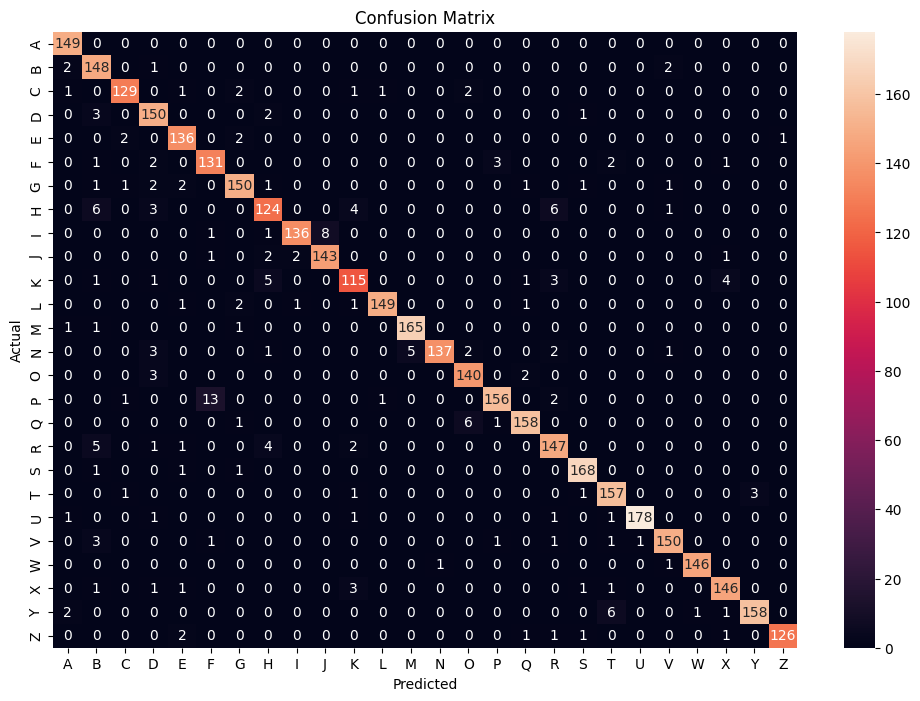

In [105]:
# Get unique class labels
class_labels = np.unique(np.concatenate((y_test_inversed, y_pred_inversed)))

# Create a heatmap from the confusion matrix
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
